In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points = 0
Title      = 'Synthetic Regression'
FUR_Weight = 0.1

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Regression_2', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [5]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6009125551140113


MLPRegressor(random_state=RandomState(MT19937) at 0x1E949BD9840)

In [6]:
Reg_Data.Random_Forest()

0.5213672170891153


RandomForestRegressor(random_state=RandomState(MT19937) at 0x1E949BD9840)

In [7]:
Reg_Data.GP()

-1.199033764700328


GaussianProcessRegressor()

In [8]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [9]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [10]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [4.46557163 2.72930028 2.39153665 3.06979331 5.13367292 6.25385879
 7.64021559 9.23348233]
Std 0:  [0.58963124 2.75301063 1.36805395 2.82361944 1.54404981 4.09482242
 3.33508491 5.07106003]


In [11]:
# Generate explantion data for Random Forest

Reg_Stats = Feature_Statistics(feature_names = Reg_Data.get_features(), mode = Reg_Data.get_mode())

if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         model         = URM_Exp.get_exp_model())


INSTANCE:  0
[25.14431306] [2.51443131e+01 1.00000004e-05] [25.14431306]
INSTANCE:  1
[113.03305073] [1.13033051e+02 1.00000004e-05] [113.03305073]
INSTANCE:  2
[-41.48448134] [-4.14844813e+01  1.00000004e-05] [-41.48448134]
INSTANCE:  3
[150.68798652] [1.50687987e+02 1.00000004e-05] [150.68798654]
INSTANCE:  4
[79.23977084] [7.92397708e+01 1.00000004e-05] [79.23977083]
INSTANCE:  5


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[-16.46739288] [-1.64673929e+01  1.00000004e-05] [-16.46739288]
INSTANCE:  6
[36.90848909] [3.69084891e+01 1.00000004e-05] [36.90848909]
INSTANCE:  7
[92.8829941] [9.28829941e+01 1.00000004e-05] [92.88299408]
INSTANCE:  8


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

[53.7424139] [5.37424139e+01 1.00000004e-05] [53.7424139]
INSTANCE:  9
[38.13922861] [3.81392286e+01 1.00000004e-05] [38.13922861]
INSTANCE:  10
[76.27656831] [7.62765683e+01 1.00000004e-05] [76.2765683]
INSTANCE:  11
[-30.67662782] [-3.06766278e+01  1.00000004e-05] [-30.67662782]
INSTANCE:  12
[25.40964188] [2.54096419e+01 1.00000004e-05] [25.40964187]
INSTANCE:  13
[119.60588973] [1.19605890e+02 1.00000004e-05] [119.60588975]
INSTANCE:  14
[54.41087104] [5.44108710e+01 1.00000004e-05] [54.41087104]
INSTANCE:  15


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[59.76581626] [5.97658162e+01 1.00000004e-05] [59.76581625]
INSTANCE:  16
[45.50461681] [4.55046168e+01 1.00000004e-05] [45.50461681]
INSTANCE:  17
[99.465763] [9.94657630e+01 1.00000004e-05] [99.46576301]
INSTANCE:  18
[92.08831786] [9.20883179e+01 1.00000004e-05] [92.0883179]
INSTANCE:  19
[51.98300913] [5.19830091e+01 1.00000004e-05] [51.98300914]
INSTANCE:  20
[69.72451137] [6.97245114e+01 1.00000004e-05] [69.72451138]
INSTANCE:  21
[-24.00756177] [-2.40075618e+01  1.00000004e-05] [-24.00756177]
INSTANCE:  22
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[110.01285826] [1.10012858e+02 1.00000004e-05] [110.01285825]
INSTANCE:  23
[65.55345965] [6.55534596e+01 1.00000004e-05] [65.55345964]
INSTANCE:  24
[122.83190839] [1.22831908e+02 1.00000004e-05] [122.83190839]
INSTANCE:  25
[32.65235659] [3.26523566e+01 1.00000004e-05] [32.65235659]
INSTANCE:  26
[-4.57624936] [-4.57624936e+00  1.00000004e-05] [-4.57624936]
INSTANCE:  27
[40.53300003] [4.05330000e+01 1.00000004e-05] [40.533

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[44.43221449] [4.44322145e+01 1.00000004e-05] [44.4322145]
INSTANCE:  32
[113.57763184] [1.13577632e+02 1.00000004e-05] [113.57763183]
INSTANCE:  33
[41.63584109] [4.16358411e+01 1.00000004e-05] [41.6358411]
INSTANCE:  34
[124.32062271] [1.24320623e+02 1.00000004e-05] [124.32062272]
INSTANCE:  35
[38.73247416] [3.87324742e+01 1.00000004e-05] [38.73247417]
INSTANCE:  36
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

[86.05007988] [8.60500796e+01 1.00000004e-05] [86.05007963]
INSTANCE:  37
[101.93532896] [1.01935329e+02 1.00000004e-05] [101.93532897]
INSTANCE:  38
[43.8517076] [4.38517076e+01 1.00000004e-05] [43.85170761]
INSTANCE:  39
[-30.77035324] [-3.07703532e+01  1.00000004e-05] [-30.77035324]
INSTANCE:  40
[40.77542972] [4.07754297e+01 1.00000004e-05] [40.77542972]
INSTANCE:  41
[36.91411156] [3.69141116e+01 1.00000004e-05] [36.91411156]
INSTANCE:  42
[67.67649398] [6.76764940e+01 1.00000004e-05] [67.67649398]
INSTANCE:  43
[32.92216711] [3.29221671e+01 1.00000004e-05] [32.92216712]
INSTANCE:  44
[164.80850435] [1.64808504e+02 1.00000004e-05] [164.8085044]
INSTANCE:  45
[69.47041956] [6.94704196e+01 1.00000004e-05] [69.47041956]
INSTANCE:  46
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[28.20464933] [2.82046493e+01 1.00000004e-05] [28.20464933]
INSTANCE:  47
[74.58734152] [7.45873415e+01 1.00000004e-05] [74.58734152]
INSTANCE:  48
[7

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[64.90054184] [6.49005418e+01 1.00000004e-05] [64.9005418]
INSTANCE:  60
[111.0343646] [1.11034365e+02 1.00000004e-05] [111.03436461]
INSTANCE:  61
[77.06173489] [7.70617349e+01 1.00000004e-05] [77.06173488]
INSTANCE:  62
[39.12857755] [3.91285776e+01 1.00000004e-05] [39.12857756]
INSTANCE:  63
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[57.4155923] [5.74155923e+01 1.00000004e-05] [57.4155923]
INSTANCE:  64
[49.70556693] [4.97055669e+01 1.00000004e-05] [49.70556694]
INSTANCE:  65
[53.18127505] [5.31812750e+01 1.00000004e-05] [53.18127505]
INSTANCE:  66
[27.55527387] [2.75552739e+01 1.00000004e-05] [27.55527387]
INSTANCE:  67
[26.6363006] [2.66363006e+01 1.00000004e-05] [26.63630061]
INSTANCE:  68
[118.1835915] [1.18183592e+02 1.00000004e-05] [118.1835915]
INSTANCE:  69
[32.90977471] [3.29097747e+01 1.00000004e-05] [32.90977471]
INSTANCE:  70
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[122.63626374] [1.22636264e+02 1.00000004e-05] [122.63626371]
INSTANCE:  71
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[101.40508893] [1.01405089e+02 1.00000004e-05] [101.40508894]
INSTANCE:  72
[123.3576147] [1.23357615e+02 1.00000004e-05] [123.35761468]
INSTANCE:  73
[19.39087092] [1.93908709e+01 1.00000004e-05] [19.39087092]
INSTANCE:  74
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[54.12226291] [5.41222629e+01 1.00000004e-05] [54.12226292]
INSTANCE:  75
[107.24122487] [1.07241225e+02 1.00000004e-05] [107.24122488]
INSTANCE:  76
[56.37578196] [5.63757820e+01 1.00000004e-05] [56.37578196]
INSTANCE:  77
[94.69971902] [9.46997191e+01 1.00000004e-05] [94.6997191]
INSTANCE:  78
[61.5185889] [6.15185889e+01 1.00000004e-05] [61.51858893]
INSTANCE:  79
[-15.4983071] [-1.54983071e+01  1.00000004e-05] [-15.4983071]
INSTANCE:  80
[94.75655658] [9.47565566e+01 1.00000004e-05] [94.75655658]
INSTANCE:  81
[78.23379221] [7.82337924e+01 1.00000004e-05] [78.23379239]
INSTANCE:  82
[36.22870998] [3.62287100

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

[-9.62344778] [-9.62344778e+00  1.00000004e-05] [-9.62344778]
INSTANCE:  87
[27.83933116] [2.78393312e+01 1.00000004e-05] [27.83933116]
INSTANCE:  88
[145.84832373] [1.45848324e+02 1.00000004e-05] [145.84832365]
INSTANCE:  89


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

[14.39295547] [1.43929555e+01 1.00000004e-05] [14.39295547]
INSTANCE:  90


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[11.07696234] [1.10769623e+01 1.00000004e-05] [11.07696234]
INSTANCE:  91
[142.06697668] [1.42066977e+02 1.00000004e-05] [142.06697665]
INSTANCE:  92
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[64.25615053] [6.42561505e+01 1.00000004e-05] [64.25615053]
INSTANCE:  93
[44.01975911] [4.40197591e+01 1.00000004e-05] [44.01975912]
INSTANCE:  94
[27.60630633] [2.76063063e+01 1.00000004e-05] [27.60630634]
INSTANCE:  95
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[70.98194331] [7.09819433e+01 1.00000004e-05] [70.98194333]
INSTANCE:  96
[74.22450634] [7.42245064e+01 1.00000004e-05] [74.22450635]
INSTANCE:  97
[27.21158926] [2.72115893e+01 1.00000004e-05] [27.21158927]
INSTANCE:  98
[71.29599045] [7.12959905e+01 1.00000004e-05] [71.29599047]
INSTANCE:  99
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[49.12382437] [4.91238244e+01 1.00000004e-05] [49.12382438]


In [12]:
import matplotlib.pyplot as plt


In [13]:
print(f_predict)
print(e_predict)


[49.12382437]
[4.91238244e+01 1.00000004e-05]


In [14]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


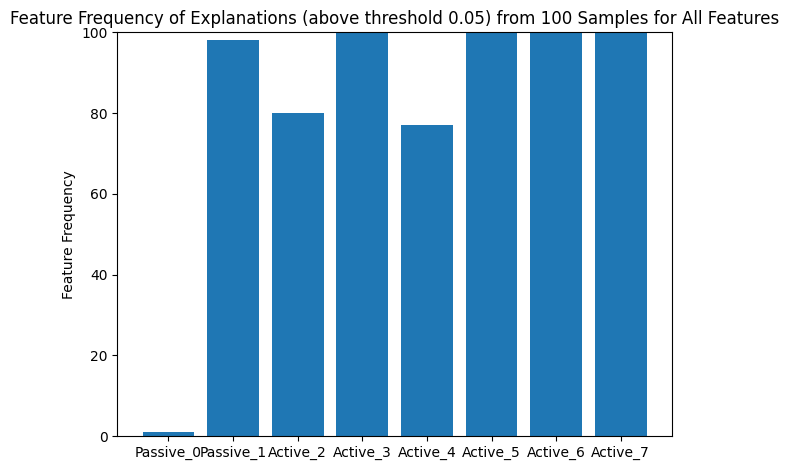

In [15]:
Reg_Stats.Frequency_Plot()


In [16]:
Reg_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           27.83213289080884  :  444.1684489738768  :  92.2608237400431
y - exp(x):          27.832132885218762  :  444.16844880384104  :  92.26082378093362
BB(x) - exp(x):      1.402480713785792e-08  :  1.060291543157125e-15  :  2.5798399860832433e-07
Average exp(x) var:  1.0000000413701844e-05


In [17]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.800942760942761
Mean Jaccard Distance:    0.1990572390572391


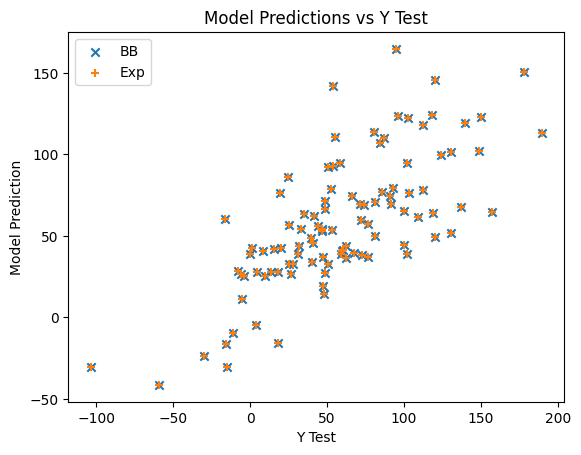

In [18]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (100, 8)


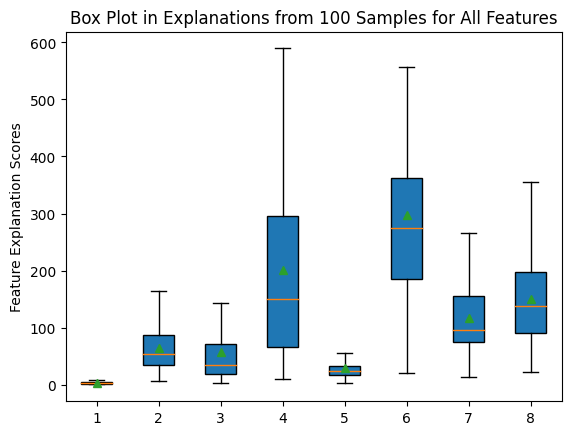

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [19]:
Reg_Stats.Box_Plot()


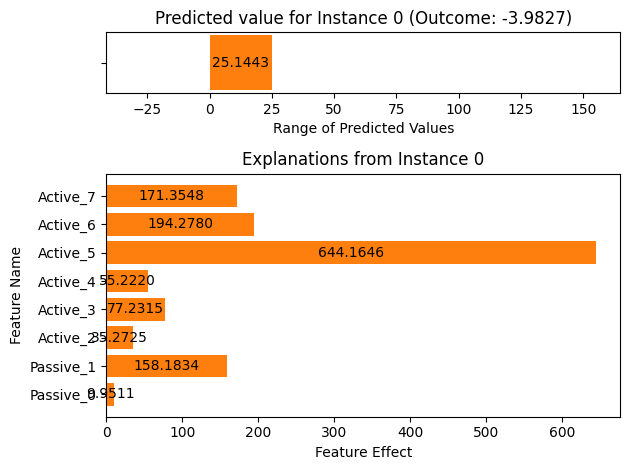

In [20]:
Reg_Stats.View_Explanation(instance = 0)

In [21]:
scores = URM_Exp.permutation_importance()
    


In [22]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[3.6871637  3.50712226 4.19255968 3.62028578 3.35827951 5.53187285
 4.42020242 4.14358071]


In [23]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[ 1.00413159  7.91804411  8.19838727  8.05524193  4.43022286 19.16776113
 15.05093119 14.3895803 ]


In [24]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[2.37689654e-01 1.58972605e-04 9.69657459e-03 4.87096705e-01
 7.83479360e-01 1.44948234e+00 2.32832830e+00 2.70406809e+00]


In [25]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

[2.73663819e-06 4.56841837e-04 1.97529847e-04 7.99929414e+00
 4.71922878e-06 2.55943900e-05 2.23395509e-06 1.62075586e-05]


In [26]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[ 7.69306466 -0.91630501  4.69415317 -0.07424647  1.70607295  4.44930626
  3.73962695 -0.06230467]


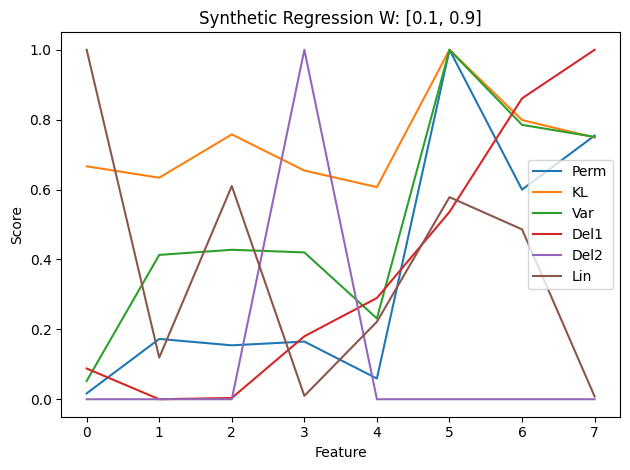

In [27]:
URM_Exp.plot_scores(Title, FUR_Weight)

In [28]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.40904634e-01  5.41183330e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.19697709e-01 -2.27381455e-01  7.51180686e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [29]:
acq_data.Create_BB_plot()

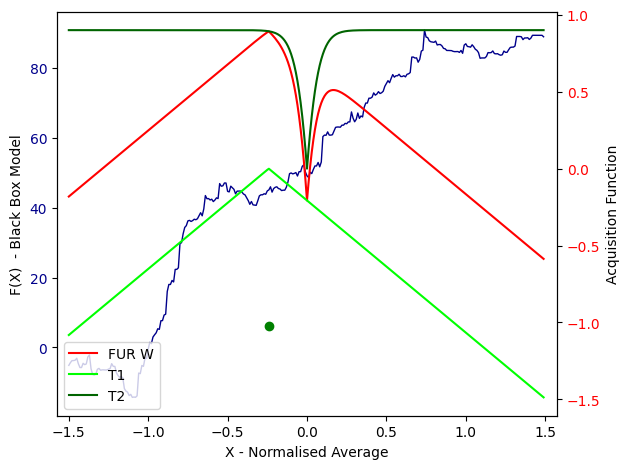

In [30]:
acq_data.plot_point(0)

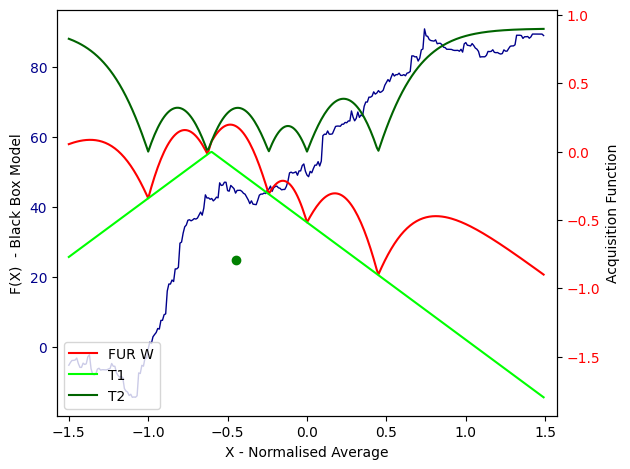

In [31]:
acq_data.plot_point(5)

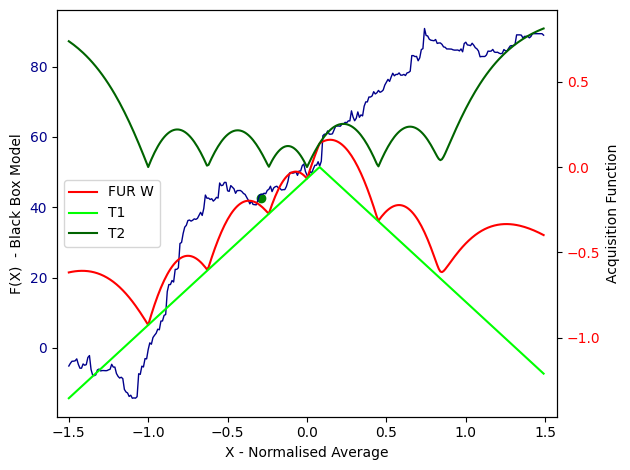

In [32]:
acq_data.plot_point(10)

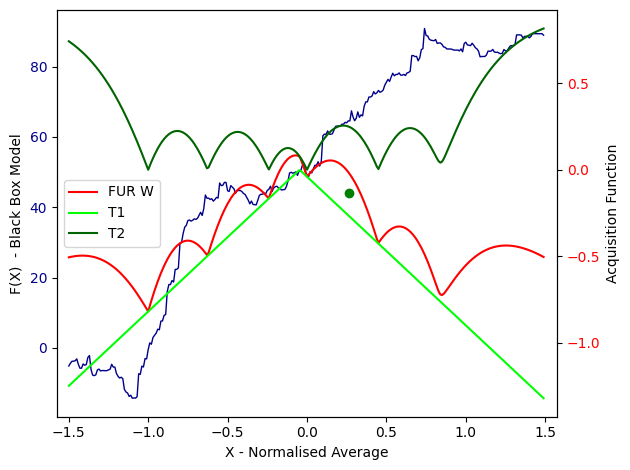

In [33]:
acq_data.plot_point(15)

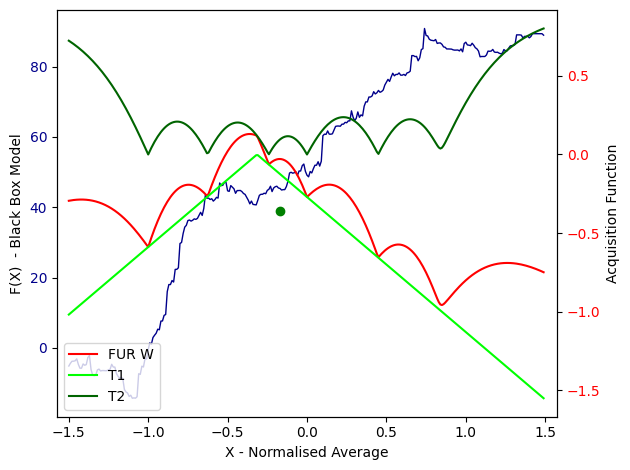

In [34]:
acq_data.plot_point(19)

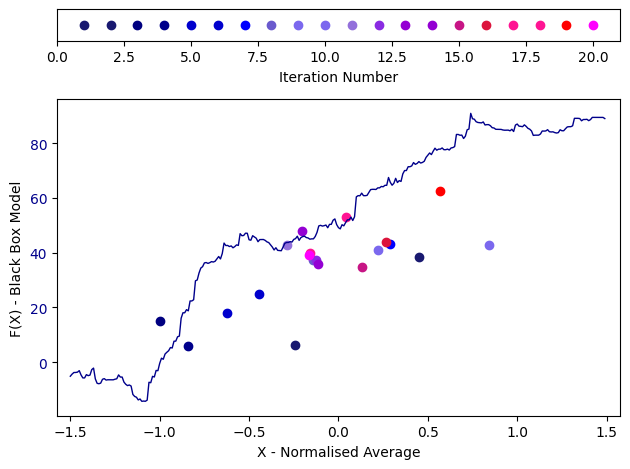

In [35]:
acq_data.plot_all()

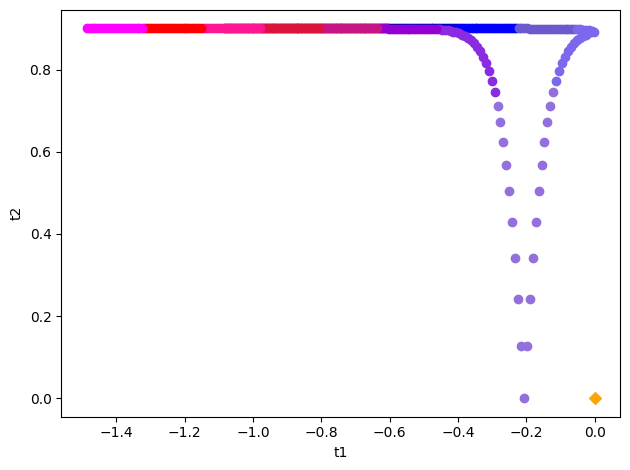

In [36]:
acq_data.plot_t1_t2(0)

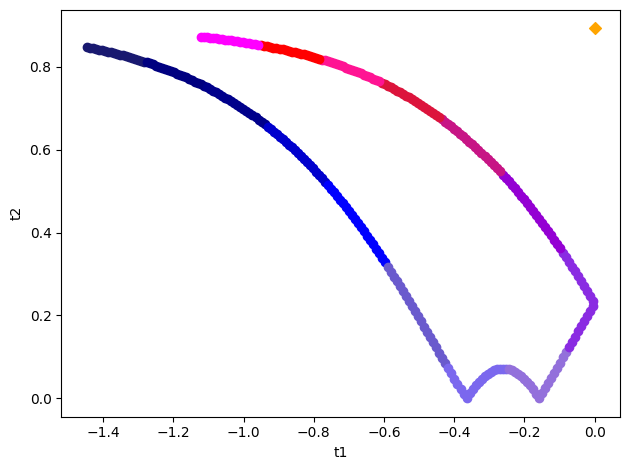

In [37]:
acq_data.plot_t1_t2(1)

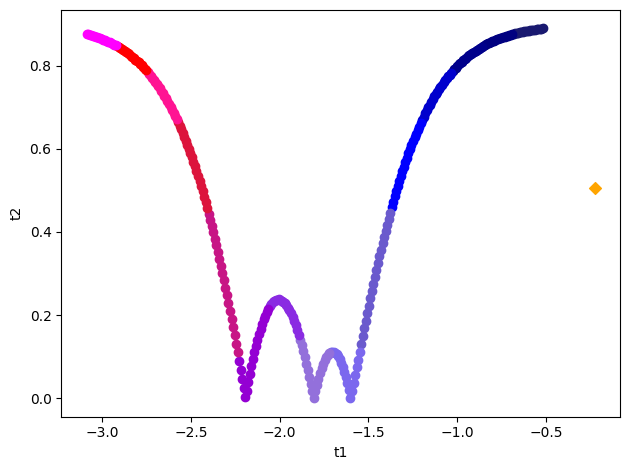

In [38]:
acq_data.plot_t1_t2(2)

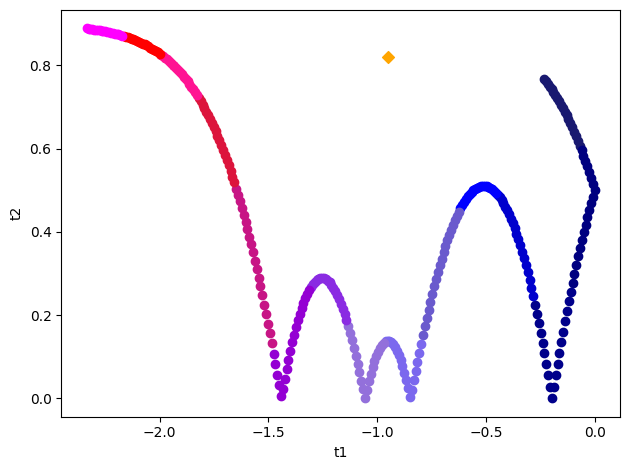

In [39]:
acq_data.plot_t1_t2(3)

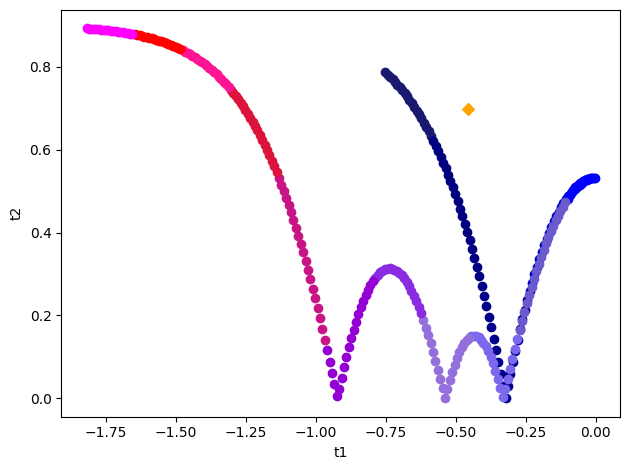

In [40]:
acq_data.plot_t1_t2(4)

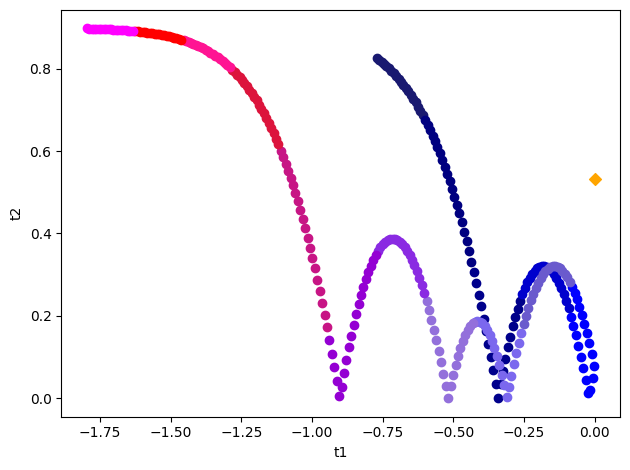

In [41]:
acq_data.plot_t1_t2(5)

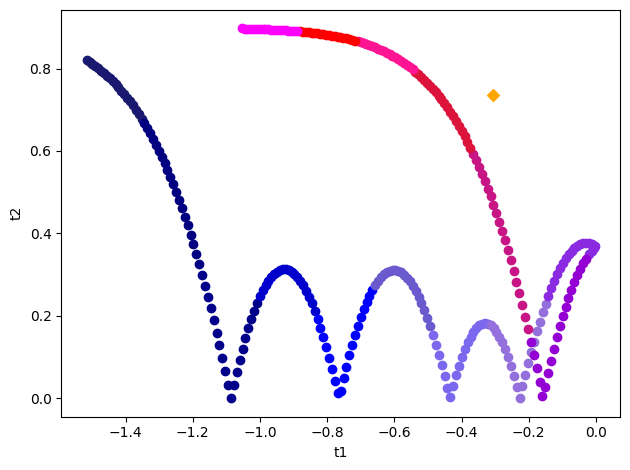

In [42]:
acq_data.plot_t1_t2(6)

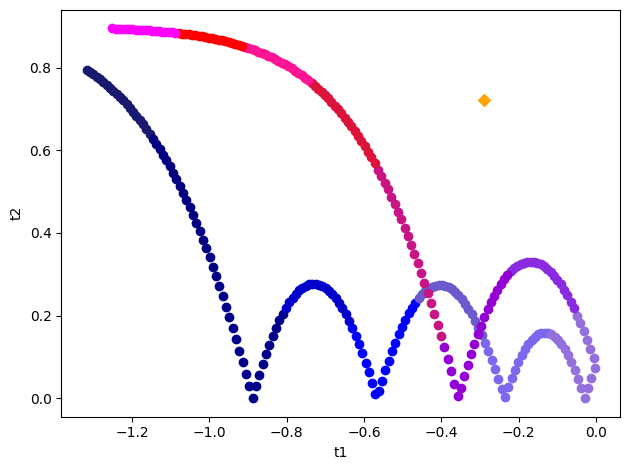

In [43]:
acq_data.plot_t1_t2(7)

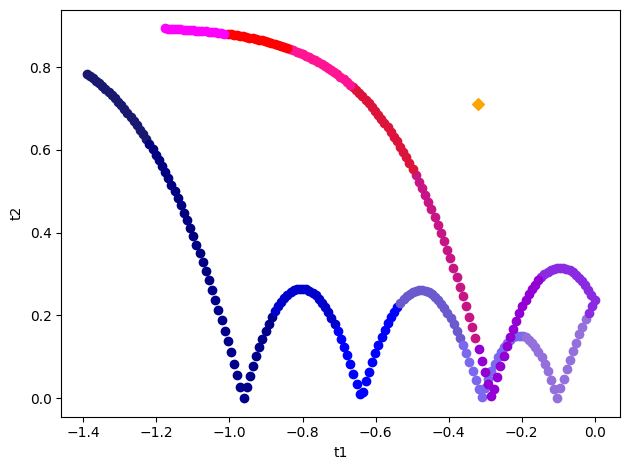

In [44]:
acq_data.plot_t1_t2(8)

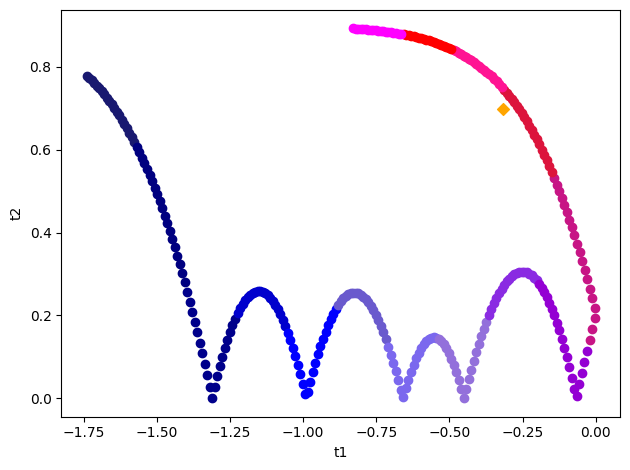

In [45]:
acq_data.plot_t1_t2(9)

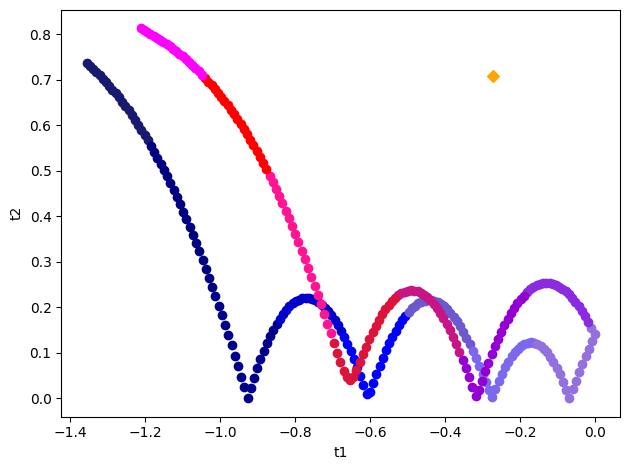

In [46]:
acq_data.plot_t1_t2(10)

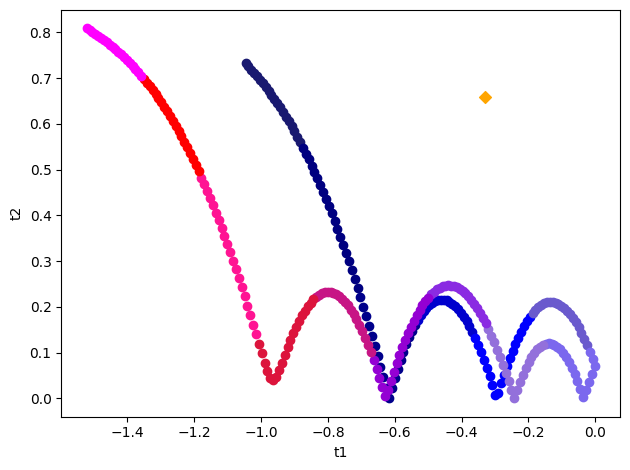

In [47]:
acq_data.plot_t1_t2(11)

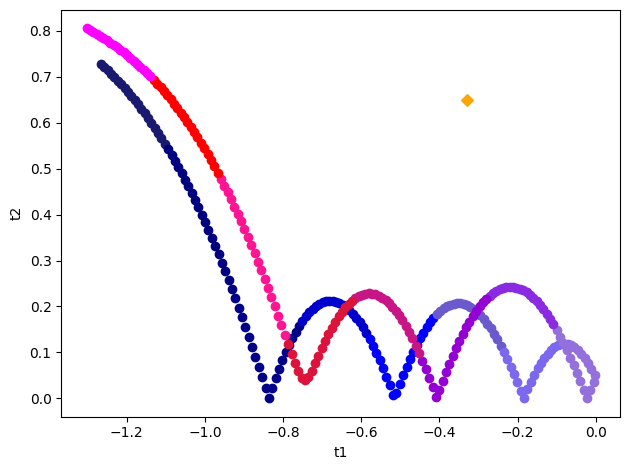

In [48]:
acq_data.plot_t1_t2(12)

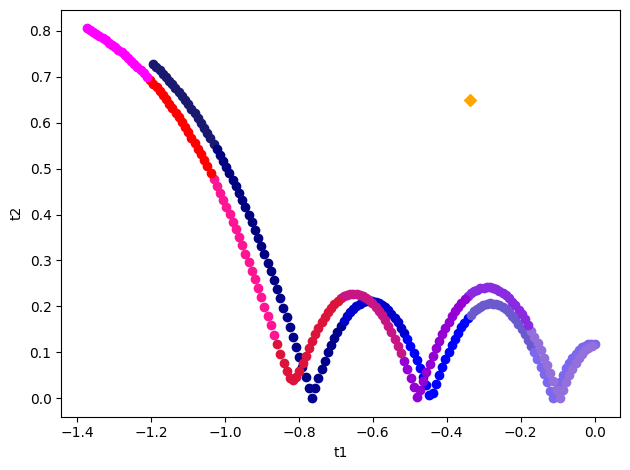

In [49]:
acq_data.plot_t1_t2(13)

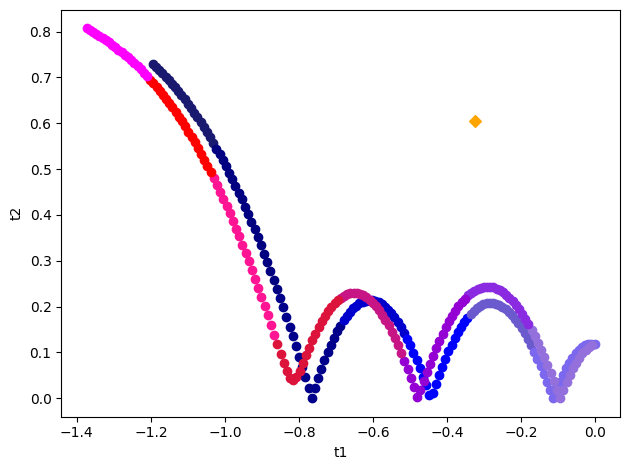

In [50]:
acq_data.plot_t1_t2(14)

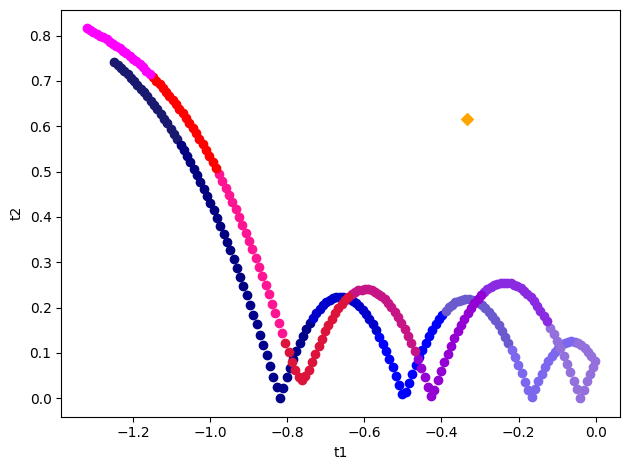

In [51]:
acq_data.plot_t1_t2(15)

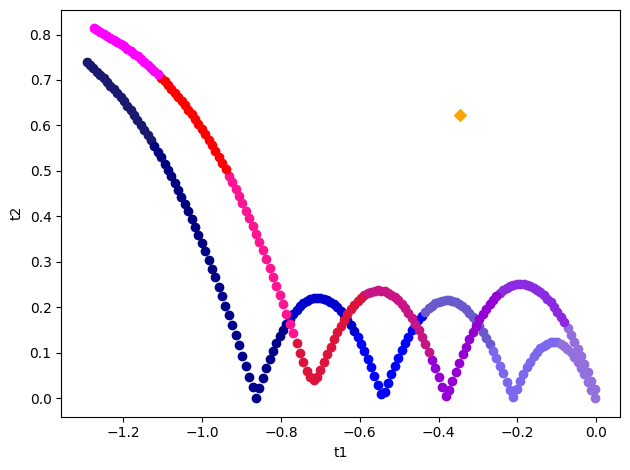

In [52]:
acq_data.plot_t1_t2(16)

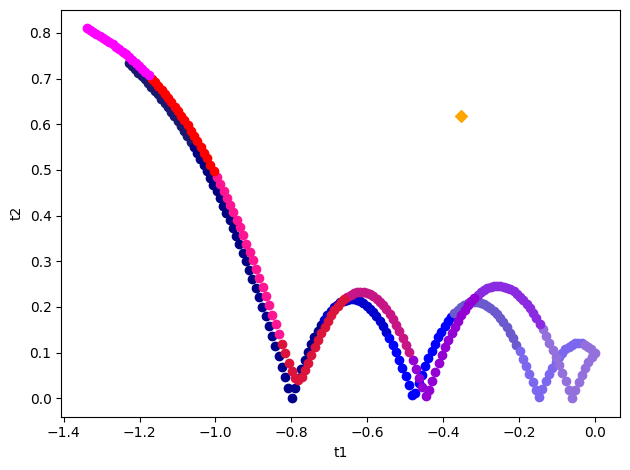

In [53]:
acq_data.plot_t1_t2(17)

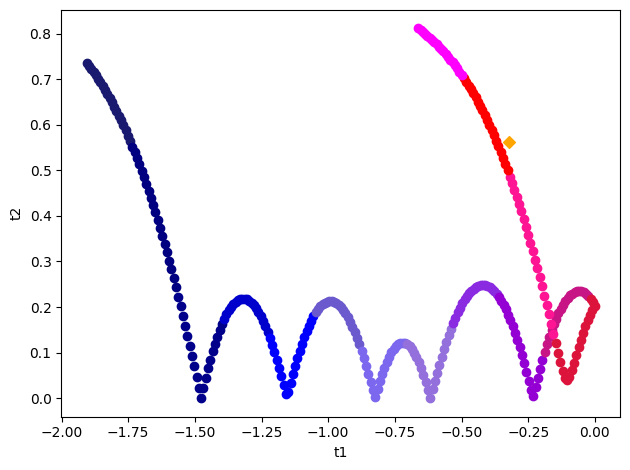

In [54]:
acq_data.plot_t1_t2(18)

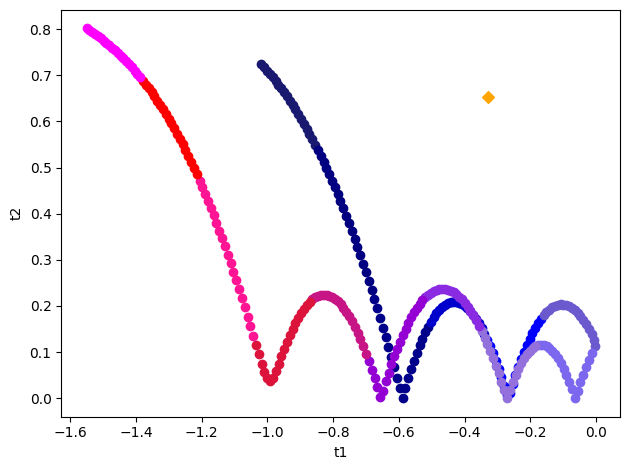

In [55]:
acq_data.plot_t1_t2(19)